In [3]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.special import linestyle
from tqdm import tqdm
import scipy
import pandas as pd

In [4]:
# SHARED
_k_b = scipy.constants.k
_rho = 4400
_rho_f = 790
_r = 2.738*10**-6
_m = 4/3 *np.pi *_r**3*_rho
_temp = 293
_viscous = 0.36e-3
_v_force = 6*np.pi*_r*_viscous

_K = 6.184e-5#9.384e-5 # Need to adjust

# TOLERANCES
tols = [.05, .2, .5, 1]

In [5]:
# Calculate the average MSD
def compute_msd(time_trace, dt):
    n = len(time_trace)
    msd = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(n) * dt  # Calculate lag times

    for tau in tqdm(range(n)):
        displacements = time_trace[tau:] - time_trace[:n - tau]
        msd[tau] = np.mean(displacements**2)

    return msd, lag_times

# Calculate the zero init MSD
def compute_init_msd(time_trace, dt):

    n = len(time_trace)
    lag_times = np.arange(n) * dt  # Calculate lag times

    msd = [(time_trace[0]-time_trace[i])**2 for i in range(n)]
    return msd, lag_times


In [6]:
# ANALYTICAL FUNCTIONS

# GENERAL WHITE NOISE
def msd_wn(t):
    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    return (2*_k_b*_temp/_K)*(1-np.exp(-t/(2*tau))*(np.cosh(omega_1*t)+(1/(2*omega_1*tau))*np.sinh(omega_1*t)))

# INITIALLY ZERO WHITE NOISE
def just_noise(t):

    tau = _m / _v_force
    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
    denominator = -2 + 8*tau**2*omega_1**2#-1*8*tau**2*omega_0**2
    final_scale = 12*np.pi*_r*_viscous*_k_b*_temp / _m**2 / omega_1**2
    return (numerator / denominator) * final_scale

# INITIAL SET VARIANCE WHITE NOISE
def known_initial_v_0(t, tol_percent):

    tau = _m / _v_force

    #Defines important auxillary variables

    omega_0 = np.sqrt(_K / _m)
    omega_1 = np.sqrt(1/(4*tau**2) - omega_0**2)
    T = omega_1*t

    #Gets contribution from the thermal white noise
    gamma = just_noise(t)

    #Gets contribution from initial position variation
    # hyp_factors = np.exp(-1*t/tau)*(np.cosh(T)**2 + 1/(4*(omega_1*tau)**2)*np.sinh(T)**2 + 1/(omega_1*tau)*np.cosh(T)*np.sinh(T)) - np.exp(-1*t/(2*tau))*(2*np.cosh(T) - 1/(2*omega_1*tau)*np.sinh(T))
    hyp_factors = (1 - np.exp(-t/(2*tau))*(np.cosh(omega_1*t) + np.sinh(omega_1*t)/(2*omega_1*tau)))**2

    #alpha easier to type than tol_percent
    alpha = tol_percent

    #Gets the second moment of the velocity assuming a probabiity distribution of
    #a Gaussian cut off on its wings by some fraction of its standard deviation (alpha/tol_percent)
    updated_sigma = 1 - alpha*np.exp(-alpha**2/2)*np.sqrt(2/np.pi)/scipy.special.erf(alpha/np.sqrt(2))

    #Calculates the contribution from the intitial velocity spread
    velo = np.exp(-1*t/tau) / omega_1**2 * np.sinh(omega_1*t)**2 *_k_b*_temp / _m * updated_sigma

    #Puts the pieces together
    return _k_b*_temp / _K * ( hyp_factors) + gamma + velo

# HYDRODYNAMIC GENERAL CASE
def hydro_msd(t):
    trap_const = _K
    use_mass = _m
    m_f = 2 / 3 * np.pi * _r ** 3 * 1000
    t_k = (6 * np.pi * _r * _viscous) / _K
    t_f = (_rho_f * _r ** 2) / _viscous
    t_p = _m / (6 * np.pi * _r * _viscous)
    print(t_p)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = _k_b * _temp / (6 * np.pi * _viscous * _r)
    # Returns theoretical MSD
    return np.real(2 * _k_b * _temp / trap_const + 2 * _k_b * _temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))

In [7]:
# SIMULATIONS

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\Cole Thumann\Desktop\Lab_Repos\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep_sim = df['real_timestep_s'].values[0]

positions_sim = np.array([df[col].astype(float).values for col in position_cols])
velocities_sim = np.array([df[col].astype(float).values for col in velocity_cols])

# Optionally, convert to numpy arrays with shape (num_traces, num_points)
# positions_sim = np.array(positions_sim)
# velocities_sim = np.array(velocities_sim)

# Print the shapes to verify
print(f"Positions shape: {positions_sim.shape}")
print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 100
fs_sim = 1/(timestep_sim * bin_num_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)


# GET THE EQ MSD
all_msd_sim = []
lag_times_sim = 0
for series in traces_sim:
    msd, lag_times_sim = compute_msd(series, timestep_sim*bin_num_sim)
    all_msd_sim.append(msd)

eq_msd_sim = np.mean(all_msd_sim, axis=0)



Positions shape: (1, 4546948)
Velocities shape: (1, 4546948)


100%|██████████| 45469/45469 [00:00<00:00, 73800.84it/s]


In [8]:
# SIM PART 2

# GET THE VAR INT MSD
# CONDITIONING (Find spots where velocity is zero)
sim_tol_msds = []
init_lag_times_sim = 0

for tol in tols:
    all_init_msd_sim = []
    init_len = int(len(traces_sim[0])/2)
    
    for i in range(len(traces_sim)):
        zero_idxs_sim = []
        v_tolerance = (tol * np.std(v_traces_sim[i]))
        p_tolerance = (tol * np.std(traces_sim[i]))
        v_indices = np.where(abs(v_traces_sim[i]) < v_tolerance)[0]
        print("v idx sim: " + str(len(v_indices)))
        p_indices = np.where(abs(traces_sim[i]) < p_tolerance)[0]
        print("p idx sim: " + str(len(p_indices)))
    
        # Add the idx that appear in both arrays
        for idx in v_indices:
            if idx in p_indices:
                if idx + init_len < len(traces_sim[i]):
                    zero_idxs_sim.append(idx)
    
        print("total idx sim: " + str(len(zero_idxs_sim)))
    
        for idx in zero_idxs_sim:
            msd, init_lag_times_sim = compute_init_msd(traces_sim[i][idx:idx+init_len], timestep_sim*bin_num_sim)
            all_init_msd_sim.append(msd)
    
    init_msd_sim = np.mean(all_init_msd_sim, axis=0)
    sim_tol_msds.append(init_msd_sim)

v idx sim: 1799
p idx sim: 1119
total idx sim: 15
v idx sim: 7069
p idx sim: 5501
total idx sim: 376
v idx sim: 17057
p idx sim: 14865
total idx sim: 2460
v idx sim: 30723
p idx sim: 28394
total idx sim: 9898


In [10]:
# DATA

timestep_data = 0.825E-6

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks1 = []

for chunk in pd.read_csv(r'C:\Users\Cole Thumann\Desktop\LabData\Max_Data1\calibrated_2.7_micron_position.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks1.append(chunk)

data_df_pos_data = pd.concat(chunks1, ignore_index=True)

chunks2 = []

for chunk in pd.read_csv(r'C:\Users\Cole Thumann\Desktop\LabData\Max_Data1\calibrated_2.7_micron_velocity.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks2.append(chunk)

data_df_vel_data = pd.concat(chunks2, ignore_index=True)

# Convert DataFrame into a numpy array where each column is an entry
traces_data = data_df_pos_data.to_numpy().T  # transpose if you want each col as an entry

# Convert DataFrame into a numpy array where each column is an entry
v_traces_data = data_df_vel_data.to_numpy().T  # transpose if you want each col as an entry


# GET THE EQ MSD
all_msd_data = []
lag_times_data = 0
for series in traces_data:
    msd, lag_times_data = compute_msd(series, timestep_data)
    all_msd_data.append(msd)

eq_msd_data = np.mean(all_msd_data, axis=0)


100%|██████████| 50840/50840 [00:00<00:00, 60953.25it/s]


In [11]:
# DATA PT 2
# SIM PART 2

# GET THE VAR INT MSD
# CONDITIONING (Find spots where velocity is zero)
data_tol_msds = []
init_lag_times_data = 0

for tol in tols:
        
    all_init_msd_data = []
    init_len = int(len(traces_data[0])/2)
    
    msd_num_lim = 1000
    j = 0
    
    for i in range(len(traces_data)):
        zero_idxs_data = []
        
        v_tolerance = (tol * np.std(v_traces_data[i]))
        p_tolerance = (tol * np.std(traces_data[i]))
        
        v_indices = np.where(abs(v_traces_data[i]) < v_tolerance)[0]
        print("v idx data: " + str(len(v_indices)))
        p_indices = np.where(abs(traces_data[i]) < p_tolerance)[0]
        print("p idx data: " + str(len(p_indices)))
    
        # Add the idx that appear in both arrays
        for idx in v_indices:
            if idx in p_indices:
                if idx + init_len < len(traces_data[i]):
                    zero_idxs_data.append(idx)
    
        print("total idx data: " + str(len(zero_idxs_data)))
    
        for idx in zero_idxs_data:
            j+=1
            if j > msd_num_lim:
                break
            msd, init_lag_times_data = compute_init_msd(traces_data[i][idx:idx+init_len], timestep_data)
            all_init_msd_data.append(msd)
    
    init_msd_data = np.mean(all_init_msd_data, axis=0)
    data_tol_msds.append(init_msd_data)

v idx data: 2075
p idx data: 2573
total idx data: 54
v idx data: 1992
p idx data: 2248
total idx data: 41
v idx data: 1999
p idx data: 1623
total idx data: 44
v idx data: 2085
p idx data: 1922
total idx data: 45
v idx data: 2004
p idx data: 2092
total idx data: 48
v idx data: 1963
p idx data: 2117
total idx data: 41
v idx data: 2002
p idx data: 1870
total idx data: 42
v idx data: 2012
p idx data: 2141
total idx data: 48
v idx data: 2027
p idx data: 1453
total idx data: 42
v idx data: 1945
p idx data: 1978
total idx data: 28
v idx data: 2029
p idx data: 1827
total idx data: 21
v idx data: 2007
p idx data: 2003
total idx data: 43
v idx data: 8034
p idx data: 9874
total idx data: 872
v idx data: 7861
p idx data: 8616
total idx data: 752
v idx data: 8181
p idx data: 6834
total idx data: 559
v idx data: 8301
p idx data: 7340
total idx data: 603
v idx data: 7978
p idx data: 8496
total idx data: 738
v idx data: 7898
p idx data: 7976
total idx data: 638
v idx data: 8194
p idx data: 7205
total 

C:\Users\Cole Thumann\AppData\Local\Temp\ipykernel_21772\2107893332.py:16: RuntimeWarning: overflow encountered in exp
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\Cole Thumann\AppData\Local\Temp\ipykernel_21772\2107893332.py:16: RuntimeWarning: overflow encountered in cosh
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\Cole Thumann\AppData\Local\Temp\ipykernel_21772\2107893332.py:16: RuntimeWarning: invalid value encountered in add
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*t*omega_1)+2*tau*omega_1*np.sinh(2*t*omega_1))
C:\Users\Cole Thumann\AppData\Local\Temp\ipykernel_21772\2107893332.py:16: RuntimeWarning: overflow encountered in sinh
  numerator = tau*np.exp(-1*t / tau)*(-1-4*tau**2*(-1 + np.exp(t/tau))*omega_1**2 + np.cosh(2*

2.0361255308641968e-05


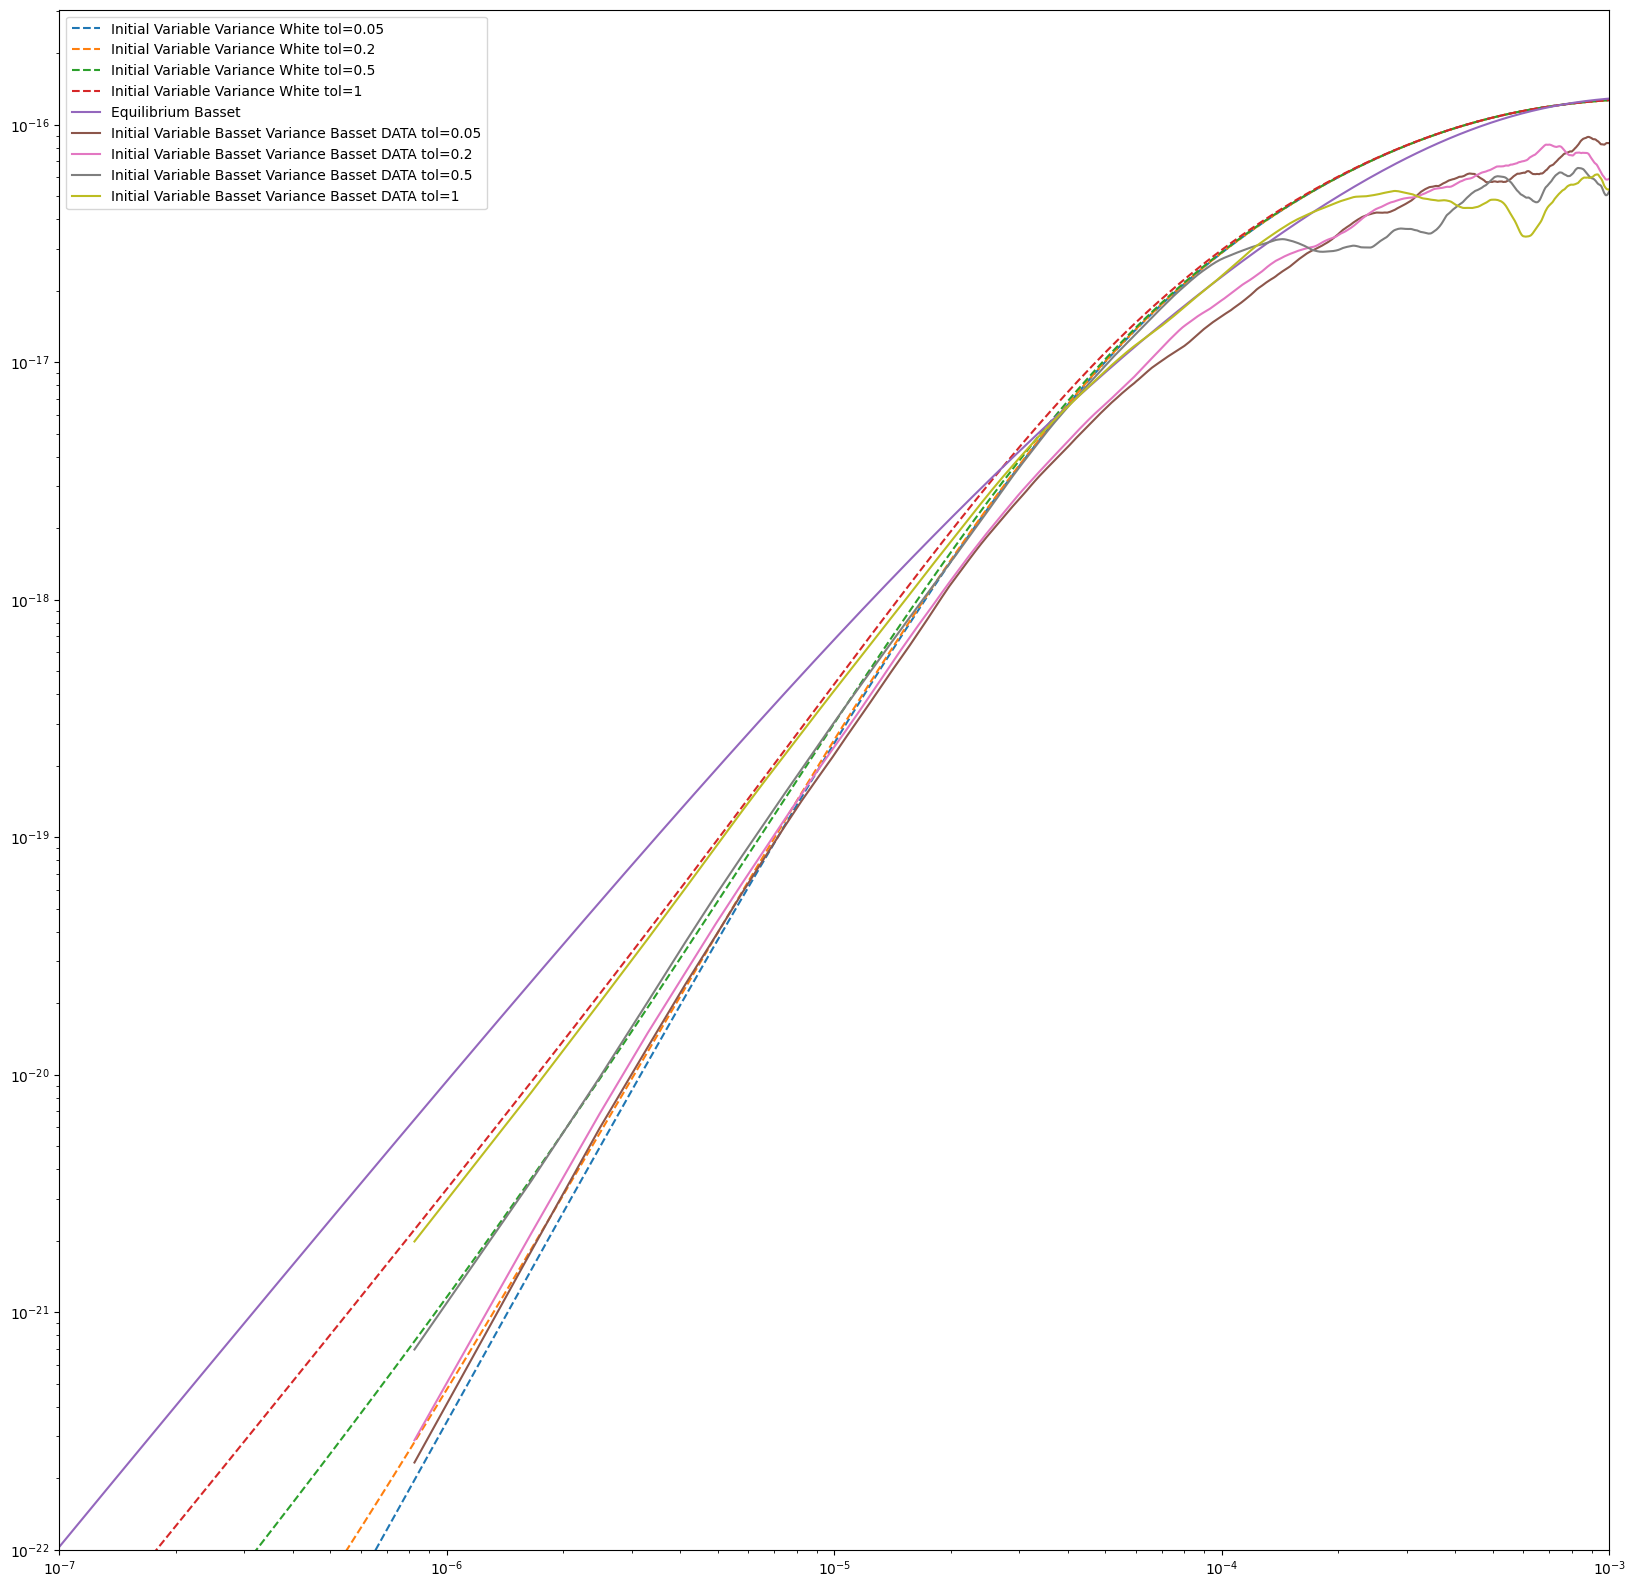

In [16]:
# GRAPHING
plt.figure(figsize=(20,20))

#  Set times for analytic functions
times_analytic = np.logspace(-8, 1, 1000)

init_zero_WN_analytic = just_noise(times_analytic)
analytic_tol_msds = []
for tol in tols:
    init_var_WN_analytic = known_initial_v_0(times_analytic, tol)
    analytic_tol_msds.append(init_var_WN_analytic)
WN_EQ_analytic = msd_wn(times_analytic)
basset_msd = hydro_msd(times_analytic)

# ANALYTIC GRAPHING
# plt.plot(times_analytic, init_zero_WN_analytic, label="Initial Zero White")
for i in range(len(tols)):
    plt.plot(times_analytic, analytic_tol_msds[i], linestyle='dashed', label=f"Initial Variable Variance White tol={tols[i]}")
# plt.plot(times_analytic, WN_EQ_analytic, linestyle='dashed', label="Equilibrium Initial Variance White")
plt.plot(times_analytic, basset_msd, label="Equilibrium Basset")

# SIMULATION GRAPHING
# plt.plot(lag_times_sim[1:], eq_msd_sim[1:], label="Equilibrium Basset SIM")
# for i in range(len(tols)):
#     plt.plot(init_lag_times_sim[1:], sim_tol_msds[i][1:], label=f"Initial Variable Basset Variance Basset SIM tol={tols[i]}")

# DATA GRAPHING
# plt.plot(lag_times_data[1:], eq_msd_data[1:], label="Equilibrium Basset DATA")
for i in range(len(tols)):
    plt.plot(init_lag_times_data[1:], data_tol_msds[i][1:], label=f"Initial Variable Basset Variance Basset DATA tol={tols[i]}")

plt.xlim(left=1E-7)
plt.xlim(right=1E-3)
plt.ylim(bottom=1E-22)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
